In [ ]:
import numpy as np
import random 
import matplotlib.pyplot as plt
import os
import time
import glob
from collections import Counter

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models
from torch.utils.data import Dataset, DataLoader
import cv2

%matplotlib inline

In [ ]:
from torchvision import transforms
from PIL import Image
import albumentations as A

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Установка random seed для воспроизводимости
RANDOM_SEED = 42
torch_seed = 2
np.random.seed(RANDOM_SEED)
torch.manual_seed(torch_seed)

In [ ]:
path = "gdrive/MyDrive/SF/Progect_1_define_celebrity/data"

In [ ]:
# Определение размера исходных данных
size_train = []
size_val = []
for flag in ['train', 'valid']:
  for folders_name in sorted(os.listdir(path + "/" + flag)):
    for img_path in glob.glob(path + "/" + flag + "/" + folders_name + "/*.jpg"):
      img_pre = cv2.imread(img_path)
      if flag =='train':
        size_train.append(img_pre.shape)
      else:
        size_val.append(img_pre.shape)

print('Размеры изображений в тренировочной выборке ', set(size_train))
print('Размеры изображений в валидационной выборке ', set(size_val))

Размеры изображений в тренировочной выборке  {(285, 229, 3), (70, 70, 3)}
Размеры изображений в валидационной выборке  {(70, 70, 3)}


In [ ]:
# Количество изображений с разными размерами
dict(zip(list(size_train),[list(size_train).count(i) for i in list(size_train)]))

{(70, 70, 3): 2999, (285, 229, 3): 1}

In [ ]:
# Создание класса CustomDataset и передача аргумента Dataset, 
# чтобы он мог наследовать функционал класса Torch Dataset

class CustomDataset(Dataset):
    def __init__(self, train_flag, my_path = path, fine_tuning = False):
        self.train_flag = train_flag
        self.imgs_path = my_path
        self.data = []
        self.classes = []
        self.data_normalize = A.Normalize(mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225])

        # Добавление пути файла для каждого изображения в список self.data вместе с соответствующим именем класса
        for folders_name in sorted(os.listdir
                                   (self.imgs_path + "/" + self.train_flag)):
          self.classes.append(folders_name)
          for img_path in glob.glob(self.imgs_path + "/"+
                                    self.train_flag + "/" +
                                    folders_name + "/*.jpg"):
            self.data.append([img_path, folders_name])


        value = (index for index in range(len(self.classes)))
        self.class_map = dict(zip(self.classes, value))
        
        self.img_dim = (256, 256)
        
        # Перемешаем данные
        random.shuffle(self.data) 
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]

        # Загрузка изображения и изменение его размера до необходимого размера
        img = cv2.imread(img_path)
        img = img[:, :, ::-1]
        img = cv2.resize(img, self.img_dim)
              
        # Скейлинг изображения: перевод пикселей от 0 до 255 к формату от 0 до 1 
        img_tensor = torch.from_numpy(img)
        img_tensor = img_tensor/255
        img_tensor = self.data_normalize(image=np.array(img_tensor))['image']
        img_tensor = torch.from_numpy(img)
        img_tensor = img_tensor.permute(2, 0, 1)

        # Словарь self.class_map обеспечивает отображение имени класса в метку
        class_id = self.class_map[class_name]
        class_id = torch.tensor([class_id])
        
        return img_tensor, class_id

In [ ]:
train_data = CustomDataset(train_flag = 'train')
val_data = CustomDataset(train_flag = 'valid')

batch_size = 5

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

Визуализация батча

In [ ]:
classes = train_data.classes
classes

['bill_gates', 'elon_musk', 'jeff_bezos', 'mark_zuckerberg', 'steve_jobs']

In [ ]:
def imshow(inp, title=None): 
    """Imshow for Tensor.""" 
    inp = inp.numpy().transpose((1, 2, 0))
    print([classes[i] for i in y_train])
    plt.figure(figsize=(10,10)) 
    plt.imshow(inp)

['elon_musk', 'steve_jobs', 'mark_zuckerberg', 'elon_musk', 'elon_musk']


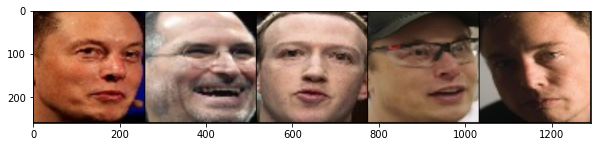

In [ ]:
X_train, y_train = next(iter(train_loader))
img = torchvision.utils.make_grid(X_train, nrow=5, scale_each= True)
imshow(img)

### Загрузка модели resnet

In [ ]:
from torchvision.models import resnet18

In [ ]:
model = resnet18(pretrained = True)
print(model)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Заморозка слоев сети resnet

In [ ]:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
# Количество нейронов, подаваемое на вход полносвязному слою
n_neurons = model.fc.in_features 
n_neurons

512

In [ ]:
# Выходное количество нейронов для классификации
num_classes = len(classes)

In [ ]:
model.fc = nn.Linear(n_neurons, num_classes)

In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Задание обучениятолько добавленного выходного полносвязного слой
for index, param in enumerate(model.fc.parameters()):
        param.requires_grad = True

In [ ]:
use_gpu = torch.cuda.is_available()
print(use_gpu)

if use_gpu:
      device = 'cuda'
else:
      device = 'cpu'

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

True


### Обучение модели

In [ ]:
# Словарь даталоудеров
dataloaders = {'train': train_loader,
               'valid': val_loader}

In [ ]:
def train_model(model, device, dataloaders, criterion, optimizer, batch_size,
                fine_tuning = False, num_epochs=25):
    since = time.time()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Обучение и валидация на каждой эпохе
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train() 
            else:
                model.eval() 
            
            current_loss = 0.0
            current_corrects = 0
            batch = 0

            # Проход по данным
            for inputs, labels in dataloaders[phase]:
                batch += 1
                inputs = inputs.float()
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Обнуление градиентов
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # Прогноз модели и рассчет лосс
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    labels = labels.squeeze(-1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Рассчет статистики
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels)
                
                # Просмотр статистики на каждых 10 батчах
                if batch%40 == 0 and phase == "train":
                  print("Batch {}, Train Loss:{:.4f}, Train ACC:{:.4f}".format(
                  batch, current_loss/(batch_size*batch),
                  100*current_corrects/(batch_size*batch)))

            epoch_loss = current_loss / CustomDataset(phase, fine_tuning = fine_tuning).__len__()
            epoch_acc = current_corrects.double() / CustomDataset(phase, fine_tuning = fine_tuning).__len__()

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
    time_elapsed = time.time() - since
    print('Время обучения: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    return model

In [ ]:
retrained = train_model(model, device, dataloaders, criterion, optimizer,  batch_size=batch_size, fine_tuning = False, num_epochs=1)

Epoch 0/0
----------
Batch 40, Train Loss:1.6327, Train ACC:33.5000
Batch 80, Train Loss:1.5191, Train ACC:38.0000
Batch 120, Train Loss:1.4430, Train ACC:40.8333
Batch 160, Train Loss:1.3699, Train ACC:44.3750
Batch 200, Train Loss:1.3026, Train ACC:47.7000
Batch 240, Train Loss:1.2588, Train ACC:49.5833
Batch 280, Train Loss:1.2217, Train ACC:51.6429
Batch 320, Train Loss:1.1883, Train ACC:53.4375
Batch 360, Train Loss:1.1546, Train ACC:55.0000
Batch 400, Train Loss:1.1305, Train ACC:56.0500
Batch 440, Train Loss:1.1062, Train ACC:57.1364
Batch 480, Train Loss:1.0854, Train ACC:58.4167
Batch 520, Train Loss:1.0614, Train ACC:59.6538
Batch 560, Train Loss:1.0455, Train ACC:60.3571
Batch 600, Train Loss:1.0308, Train ACC:61.1333
train Loss: 1.0308 Acc: 0.6113
valid Loss: 0.5027 Acc: 0.8578
Время обучения: 0m 32s


### Визуализация модели

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    fig = plt.figure()

    if use_gpu:
        device = 'cuda'
    else:
        device = 'cpu'

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs.float())
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(classes[preds[j]]))
                img = inputs.cpu().data[j]
                img = img.numpy().transpose((1, 2, 0))
                plt.imshow(img)

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

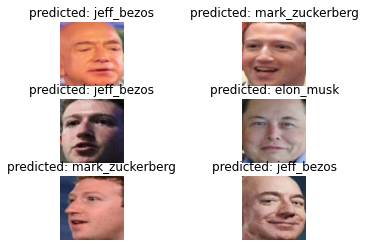

In [ ]:
visualize_model(retrained)
plt.show()